Physicochemical Properties of Protein Tertiary Structure Data Set: this is a data set of Physicochemical Properties of Protein Tertiary Structure. The data set is taken from CASP 5-9. There are 45730 decoys and size varying from 0 to 21 armstrong.
source: https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure#

In [1]:
import keras
from keras.layers import Dense
from keras.models import Sequential

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


RMSD-Size of the residue. 
F1 - Total surface area. 
F2 - Non polar exposed area. 
F3 - Fractional area of exposed non polar residue. 
F4 - Fractional area of exposed non polar part of residue. 
F5 - Molecular mass weighted exposed area. 
F6 - Average deviation from standard exposed area of residue. 
F7 - Euclidian distance. 
F8 - Secondary structure penalty. 
F9 - Spacial Distribution constraints (N,K Value).

In [3]:
data_path = "https://drive.google.com/uc?authuser=0&id=1dD0BjB9dRXI_JjNnFtuNC7AXvqSVy0JH&export=download"


column_names = ["Total surface area", "Non polar exposed area", "Fractional area of exposed non polar residue",
                "Fractional area of exposed non polar part of residue", "Molecular mass weighted exposed area",
                "Average deviation from standard exposed area of residue",
                "Euclidian distance", "Secondary structure penalty", "N_K Value"]

dataframe = pd.read_csv(data_path)

print(dataframe.head(3))

print(dataframe.isna().sum())

# Labels are RMSD
y = dataframe.RMSD

X = dataframe.loc[:, "F1":]

print(y.head(3))

print(X.head(3))

x_train, x_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2)

# Normalizing the data
scaler = StandardScaler(with_mean=True, with_std=True)

x_train = scaler.fit_transform(x_train)

x_test = scaler.transform(x_test)

print(x_train.mean())
print(x_train.std())

print(x_test.mean())
print(x_test.std())

     RMSD        F1       F2       F3        F4            F5        F6  \
0  17.284  13558.30  4305.35  0.31754  162.1730  1.872791e+06  215.3590   
1   6.021   6191.96  1623.16  0.26213   53.3894  8.034467e+05   87.2024   
2   9.275   7725.98  1726.28  0.22343   67.2887  1.075648e+06   81.7913   

        F7   F8       F9  
0  4287.87  102  27.0302  
1  3328.91   39  38.5468  
2  2981.04   29  38.8119  
RMSD    0
F1      0
F2      0
F3      0
F4      0
F5      0
F6      0
F7      0
F8      0
F9      0
dtype: int64
0    17.284
1     6.021
2     9.275
Name: RMSD, dtype: float64
         F1       F2       F3        F4            F5        F6       F7   F8  \
0  13558.30  4305.35  0.31754  162.1730  1.872791e+06  215.3590  4287.87  102   
1   6191.96  1623.16  0.26213   53.3894  8.034467e+05   87.2024  3328.91   39   
2   7725.98  1726.28  0.22343   67.2887  1.075648e+06   81.7913  2981.04   29   

        F9  
0  27.0302  
1  38.5468  
2  38.8119  
-2.636588833133671e-15
0.9999999999999

In [4]:
def build_model():
    model = Sequential()
    model.add(Dense(units=64, activation="relu",
                    input_shape=(x_train.shape[1],)))
    model.add(Dense(units=64, activation="relu"))
    model.add(Dense(units=64, activation="relu"))
    model.add(Dense(units=1, ))

    model.compile(optimizer='adam', loss='mse', metrics=[
                  'mean_absolute_error', 'mean_squared_error'])

    return model


model = build_model()

print(model.summary())

W0808 19:23:02.216612 139771812226880 deprecation_wrapper.py:119] From /home/axis/anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 19:23:02.373397 139771812226880 deprecation_wrapper.py:119] From /home/axis/anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 19:23:02.389813 139771812226880 deprecation_wrapper.py:119] From /home/axis/anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 19:23:02.437719 139771812226880 deprecation_wrapper.py:119] From /home/axis/anaconda3/envs/ml/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Opti

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
# stop the training if the validation loss does not change for N epochs (patience)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

In [7]:
# K-folds Cross validation
k = 4
num_val_samples = len(x_train) // k
num_epochs = 1500
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
    # Build the Keras model (already compiled)
    
    model = build_model()
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(x_train, y_train, batch_size=16, epochs=num_epochs,
                        validation_split=0.2, verbose=1, callbacks=[early_stop])
    

processing fold # 0


W0808 19:26:08.522665 139771812226880 deprecation_wrapper.py:119] From /home/axis/anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0808 19:26:08.598526 139771812226880 deprecation_wrapper.py:119] From /home/axis/anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 29267 samples, validate on 7317 samples
Epoch 1/1500
29267/29267 [==============================] - 18s 599us/step - loss: 27.6430 - mean_absolute_error: 4.1710 - mean_squared_error: 27.6430 - val_loss: 23.4383 - val_mean_absolute_error: 3.8517 - val_mean_squared_error: 23.4383
Epoch 2/1500
29267/29267 [==============================] - 5s 177us/step - loss: 23.3995 - mean_absolute_error: 3.8522 - mean_squared_error: 23.3995 - val_loss: 22.0985 - val_mean_absolute_error: 3.6659 - val_mean_squared_error: 22.0985
Epoch 3/1500
29267/29267 [==============================] - 5s 177us/step - loss: 22.1193 - mean_absolute_error: 3.7052 - mean_squared_error: 22.1193 - val_loss: 20.8987 - val_mean_absolute_error: 3.5792 - val_mean_squared_error: 20.8987
Epoch 4/1500
29267/29267 [==============================] - 5s 177us/step - loss: 21.1976 - mean_absolute_error: 3.6043 - mean_squared_error: 21.1976 - val_loss: 19.9427 - val_mean_absolute_error: 3.4755 - val_mean_squared_error: 19.942

29267/29267 [==============================] - 5s 181us/step - loss: 14.2384 - mean_absolute_error: 2.7528 - mean_squared_error: 14.2384 - val_loss: 15.7488 - val_mean_absolute_error: 2.8578 - val_mean_squared_error: 15.7488
Epoch 36/1500
29267/29267 [==============================] - 5s 168us/step - loss: 14.0731 - mean_absolute_error: 2.7343 - mean_squared_error: 14.0731 - val_loss: 15.9287 - val_mean_absolute_error: 2.9471 - val_mean_squared_error: 15.9287
Epoch 37/1500
29267/29267 [==============================] - 5s 173us/step - loss: 14.0249 - mean_absolute_error: 2.7327 - mean_squared_error: 14.0249 - val_loss: 15.4012 - val_mean_absolute_error: 2.8076 - val_mean_squared_error: 15.4012
Epoch 38/1500
29267/29267 [==============================] - 5s 172us/step - loss: 13.9065 - mean_absolute_error: 2.7111 - mean_squared_error: 13.9065 - val_loss: 15.0035 - val_mean_absolute_error: 2.7470 - val_mean_squared_error: 15.0035
Epoch 39/1500
29267/29267 [==============================]

29267/29267 [==============================] - 5s 179us/step - loss: 11.7366 - mean_absolute_error: 2.4775 - mean_squared_error: 11.7366 - val_loss: 14.9782 - val_mean_absolute_error: 2.7782 - val_mean_squared_error: 14.9782
Epoch 70/1500
29267/29267 [==============================] - 5s 183us/step - loss: 11.7492 - mean_absolute_error: 2.4756 - mean_squared_error: 11.7492 - val_loss: 14.4287 - val_mean_absolute_error: 2.7137 - val_mean_squared_error: 14.4287
Epoch 71/1500
29267/29267 [==============================] - 5s 181us/step - loss: 11.6549 - mean_absolute_error: 2.4664 - mean_squared_error: 11.6549 - val_loss: 15.0356 - val_mean_absolute_error: 2.8491 - val_mean_squared_error: 15.0356
Epoch 72/1500
29267/29267 [==============================] - 5s 172us/step - loss: 11.6434 - mean_absolute_error: 2.4691 - mean_squared_error: 11.6434 - val_loss: 14.9532 - val_mean_absolute_error: 2.7269 - val_mean_squared_error: 14.9532
Epoch 73/1500
29267/29267 [==============================]

29267/29267 [==============================] - 5s 179us/step - loss: 10.4312 - mean_absolute_error: 2.3234 - mean_squared_error: 10.4312 - val_loss: 14.4154 - val_mean_absolute_error: 2.6907 - val_mean_squared_error: 14.4154
Epoch 104/1500
29267/29267 [==============================] - 5s 178us/step - loss: 10.4294 - mean_absolute_error: 2.3216 - mean_squared_error: 10.4294 - val_loss: 14.1104 - val_mean_absolute_error: 2.6419 - val_mean_squared_error: 14.1104
Epoch 105/1500
29267/29267 [==============================] - 5s 176us/step - loss: 10.4180 - mean_absolute_error: 2.3184 - mean_squared_error: 10.4180 - val_loss: 14.3897 - val_mean_absolute_error: 2.6409 - val_mean_squared_error: 14.3897
Epoch 106/1500
29267/29267 [==============================] - 5s 172us/step - loss: 10.3409 - mean_absolute_error: 2.3105 - mean_squared_error: 10.3409 - val_loss: 14.5045 - val_mean_absolute_error: 2.6632 - val_mean_squared_error: 14.5045
Epoch 107/1500
29267/29267 [===========================

29267/29267 [==============================] - 5s 177us/step - loss: 9.5200 - mean_absolute_error: 2.2161 - mean_squared_error: 9.5200 - val_loss: 14.5929 - val_mean_absolute_error: 2.7012 - val_mean_squared_error: 14.5929
Epoch 138/1500
29267/29267 [==============================] - 5s 177us/step - loss: 9.4122 - mean_absolute_error: 2.2038 - mean_squared_error: 9.4122 - val_loss: 14.1281 - val_mean_absolute_error: 2.6048 - val_mean_squared_error: 14.1281
Epoch 139/1500
29267/29267 [==============================] - 5s 172us/step - loss: 9.4009 - mean_absolute_error: 2.1984 - mean_squared_error: 9.4009 - val_loss: 14.7464 - val_mean_absolute_error: 2.6925 - val_mean_squared_error: 14.7464
Epoch 140/1500
29267/29267 [==============================] - 5s 169us/step - loss: 9.4692 - mean_absolute_error: 2.2074 - mean_squared_error: 9.4692 - val_loss: 14.2400 - val_mean_absolute_error: 2.6390 - val_mean_squared_error: 14.2400
Epoch 141/1500
29267/29267 [==============================] - 5

29267/29267 [==============================] - 5s 177us/step - loss: 21.8599 - mean_absolute_error: 3.6726 - mean_squared_error: 21.8599 - val_loss: 20.9888 - val_mean_absolute_error: 3.5749 - val_mean_squared_error: 20.9888
Epoch 4/1500
29267/29267 [==============================] - 5s 177us/step - loss: 20.8615 - mean_absolute_error: 3.5558 - mean_squared_error: 20.8615 - val_loss: 20.8828 - val_mean_absolute_error: 3.6155 - val_mean_squared_error: 20.8828
Epoch 5/1500
29267/29267 [==============================] - 5s 174us/step - loss: 20.2127 - mean_absolute_error: 3.4782 - mean_squared_error: 20.2127 - val_loss: 20.1050 - val_mean_absolute_error: 3.4188 - val_mean_squared_error: 20.1050
Epoch 6/1500
29267/29267 [==============================] - 5s 175us/step - loss: 19.6238 - mean_absolute_error: 3.4034 - mean_squared_error: 19.6238 - val_loss: 19.2978 - val_mean_absolute_error: 3.3522 - val_mean_squared_error: 19.2978
Epoch 7/1500
29267/29267 [==============================] - 5

29267/29267 [==============================] - 5s 178us/step - loss: 13.7730 - mean_absolute_error: 2.6939 - mean_squared_error: 13.7730 - val_loss: 15.1119 - val_mean_absolute_error: 2.7901 - val_mean_squared_error: 15.1119
Epoch 38/1500
29267/29267 [==============================] - 5s 177us/step - loss: 13.6674 - mean_absolute_error: 2.6806 - mean_squared_error: 13.6674 - val_loss: 15.3453 - val_mean_absolute_error: 2.7911 - val_mean_squared_error: 15.3453
Epoch 39/1500
29267/29267 [==============================] - 5s 174us/step - loss: 13.6294 - mean_absolute_error: 2.6823 - mean_squared_error: 13.6294 - val_loss: 16.0074 - val_mean_absolute_error: 2.8542 - val_mean_squared_error: 16.0074
Epoch 40/1500
29267/29267 [==============================] - 5s 171us/step - loss: 13.6079 - mean_absolute_error: 2.6676 - mean_squared_error: 13.6079 - val_loss: 15.4045 - val_mean_absolute_error: 2.7903 - val_mean_squared_error: 15.4045
Epoch 41/1500
29267/29267 [==============================]

29267/29267 [==============================] - 5s 178us/step - loss: 11.6752 - mean_absolute_error: 2.4659 - mean_squared_error: 11.6752 - val_loss: 15.4718 - val_mean_absolute_error: 2.8264 - val_mean_squared_error: 15.4718
Epoch 72/1500
29267/29267 [==============================] - 5s 181us/step - loss: 11.5621 - mean_absolute_error: 2.4565 - mean_squared_error: 11.5621 - val_loss: 14.4601 - val_mean_absolute_error: 2.7265 - val_mean_squared_error: 14.4601
Epoch 73/1500
29267/29267 [==============================] - 5s 177us/step - loss: 11.6163 - mean_absolute_error: 2.4585 - mean_squared_error: 11.6163 - val_loss: 14.4677 - val_mean_absolute_error: 2.7730 - val_mean_squared_error: 14.4677
Epoch 74/1500
29267/29267 [==============================] - 5s 175us/step - loss: 11.5031 - mean_absolute_error: 2.4451 - mean_squared_error: 11.5031 - val_loss: 15.1119 - val_mean_absolute_error: 2.7799 - val_mean_squared_error: 15.1119
Epoch 75/1500
29267/29267 [==============================]

29267/29267 [==============================] - 5s 181us/step - loss: 10.3861 - mean_absolute_error: 2.3327 - mean_squared_error: 10.3861 - val_loss: 14.6166 - val_mean_absolute_error: 2.7113 - val_mean_squared_error: 14.6166
Epoch 106/1500
29267/29267 [==============================] - 5s 167us/step - loss: 10.3198 - mean_absolute_error: 2.3128 - mean_squared_error: 10.3198 - val_loss: 14.5827 - val_mean_absolute_error: 2.6807 - val_mean_squared_error: 14.5827
Epoch 107/1500
29267/29267 [==============================] - 5s 176us/step - loss: 10.2980 - mean_absolute_error: 2.3112 - mean_squared_error: 10.2980 - val_loss: 14.4512 - val_mean_absolute_error: 2.6421 - val_mean_squared_error: 14.4512
Epoch 108/1500
29267/29267 [==============================] - 5s 174us/step - loss: 10.2719 - mean_absolute_error: 2.3070 - mean_squared_error: 10.2719 - val_loss: 14.3186 - val_mean_absolute_error: 2.6706 - val_mean_squared_error: 14.3186
Epoch 109/1500
29267/29267 [===========================

29267/29267 [==============================] - 5s 178us/step - loss: 9.4290 - mean_absolute_error: 2.2196 - mean_squared_error: 9.4290 - val_loss: 14.6574 - val_mean_absolute_error: 2.7457 - val_mean_squared_error: 14.6574
Epoch 140/1500
29267/29267 [==============================] - 5s 179us/step - loss: 9.4704 - mean_absolute_error: 2.2194 - mean_squared_error: 9.4704 - val_loss: 14.3098 - val_mean_absolute_error: 2.6773 - val_mean_squared_error: 14.3098
Epoch 141/1500
29267/29267 [==============================] - 5s 176us/step - loss: 9.3278 - mean_absolute_error: 2.2072 - mean_squared_error: 9.3278 - val_loss: 14.5945 - val_mean_absolute_error: 2.7202 - val_mean_squared_error: 14.5945
Epoch 142/1500
29267/29267 [==============================] - 5s 175us/step - loss: 9.3534 - mean_absolute_error: 2.2054 - mean_squared_error: 9.3534 - val_loss: 14.6016 - val_mean_absolute_error: 2.6698 - val_mean_squared_error: 14.6016
Epoch 143/1500
29267/29267 [==============================] - 5

29267/29267 [==============================] - 5s 184us/step - loss: 15.5789 - mean_absolute_error: 2.9054 - mean_squared_error: 15.5789 - val_loss: 16.4911 - val_mean_absolute_error: 2.9566 - val_mean_squared_error: 16.4911
Epoch 24/1500
29267/29267 [==============================] - 5s 183us/step - loss: 15.4794 - mean_absolute_error: 2.8859 - mean_squared_error: 15.4794 - val_loss: 16.4301 - val_mean_absolute_error: 2.9220 - val_mean_squared_error: 16.4301
Epoch 25/1500
29267/29267 [==============================] - 5s 175us/step - loss: 15.3622 - mean_absolute_error: 2.8703 - mean_squared_error: 15.3622 - val_loss: 15.9645 - val_mean_absolute_error: 2.9395 - val_mean_squared_error: 15.9645
Epoch 26/1500
29267/29267 [==============================] - 5s 178us/step - loss: 15.1595 - mean_absolute_error: 2.8471 - mean_squared_error: 15.1595 - val_loss: 16.3624 - val_mean_absolute_error: 2.8604 - val_mean_squared_error: 16.3624
Epoch 27/1500
29267/29267 [==============================]

29267/29267 [==============================] - 5s 180us/step - loss: 12.5148 - mean_absolute_error: 2.5445 - mean_squared_error: 12.5148 - val_loss: 15.0349 - val_mean_absolute_error: 2.7699 - val_mean_squared_error: 15.0349
Epoch 58/1500
29267/29267 [==============================] - 5s 182us/step - loss: 12.4534 - mean_absolute_error: 2.5358 - mean_squared_error: 12.4534 - val_loss: 15.0116 - val_mean_absolute_error: 2.7508 - val_mean_squared_error: 15.0116
Epoch 59/1500
29267/29267 [==============================] - 5s 182us/step - loss: 12.4035 - mean_absolute_error: 2.5340 - mean_squared_error: 12.4035 - val_loss: 15.6285 - val_mean_absolute_error: 2.8102 - val_mean_squared_error: 15.6285
Epoch 60/1500
29267/29267 [==============================] - 5s 179us/step - loss: 12.4097 - mean_absolute_error: 2.5321 - mean_squared_error: 12.4097 - val_loss: 15.0157 - val_mean_absolute_error: 2.7151 - val_mean_squared_error: 15.0157
Epoch 61/1500
29267/29267 [==============================]

29267/29267 [==============================] - 5s 181us/step - loss: 10.8865 - mean_absolute_error: 2.3573 - mean_squared_error: 10.8865 - val_loss: 14.9819 - val_mean_absolute_error: 2.7279 - val_mean_squared_error: 14.9819
Epoch 92/1500
29267/29267 [==============================] - 5s 183us/step - loss: 10.7763 - mean_absolute_error: 2.3456 - mean_squared_error: 10.7763 - val_loss: 15.0232 - val_mean_absolute_error: 2.7052 - val_mean_squared_error: 15.0232
Epoch 93/1500
29267/29267 [==============================] - 5s 182us/step - loss: 10.8018 - mean_absolute_error: 2.3394 - mean_squared_error: 10.8018 - val_loss: 14.7995 - val_mean_absolute_error: 2.6887 - val_mean_squared_error: 14.7995
Epoch 94/1500
29267/29267 [==============================] - 5s 178us/step - loss: 10.8170 - mean_absolute_error: 2.3483 - mean_squared_error: 10.8170 - val_loss: 14.9765 - val_mean_absolute_error: 2.7006 - val_mean_squared_error: 14.9765
Epoch 95/1500
29267/29267 [==============================]

29267/29267 [==============================] - 5s 179us/step - loss: 9.8342 - mean_absolute_error: 2.2337 - mean_squared_error: 9.8342 - val_loss: 15.2940 - val_mean_absolute_error: 2.7039 - val_mean_squared_error: 15.2940
Epoch 126/1500
29267/29267 [==============================] - 5s 184us/step - loss: 9.8945 - mean_absolute_error: 2.2432 - mean_squared_error: 9.8945 - val_loss: 15.4687 - val_mean_absolute_error: 2.7990 - val_mean_squared_error: 15.4687
Epoch 127/1500
29267/29267 [==============================] - 5s 180us/step - loss: 9.7720 - mean_absolute_error: 2.2334 - mean_squared_error: 9.7720 - val_loss: 14.8150 - val_mean_absolute_error: 2.6280 - val_mean_squared_error: 14.8150
Epoch 128/1500
29267/29267 [==============================] - 5s 180us/step - loss: 9.7866 - mean_absolute_error: 2.2273 - mean_squared_error: 9.7866 - val_loss: 14.8189 - val_mean_absolute_error: 2.6698 - val_mean_squared_error: 14.8189
Epoch 129/1500
29267/29267 [==============================] - 5

29267/29267 [==============================] - 5s 186us/step - loss: 23.1439 - mean_absolute_error: 3.8394 - mean_squared_error: 23.1439 - val_loss: 21.7929 - val_mean_absolute_error: 3.6557 - val_mean_squared_error: 21.7929
Epoch 3/1500
29267/29267 [==============================] - 5s 185us/step - loss: 22.0318 - mean_absolute_error: 3.7071 - mean_squared_error: 22.0318 - val_loss: 21.5820 - val_mean_absolute_error: 3.6560 - val_mean_squared_error: 21.5820
Epoch 4/1500
29267/29267 [==============================] - 5s 180us/step - loss: 21.2537 - mean_absolute_error: 3.6084 - mean_squared_error: 21.2537 - val_loss: 20.5469 - val_mean_absolute_error: 3.5165 - val_mean_squared_error: 20.5469
Epoch 5/1500
29267/29267 [==============================] - 5s 181us/step - loss: 20.6804 - mean_absolute_error: 3.5417 - mean_squared_error: 20.6804 - val_loss: 19.5291 - val_mean_absolute_error: 3.4487 - val_mean_squared_error: 19.5291
Epoch 6/1500
29267/29267 [==============================] - 5

29267/29267 [==============================] - 5s 185us/step - loss: 14.1892 - mean_absolute_error: 2.7440 - mean_squared_error: 14.1892 - val_loss: 15.1779 - val_mean_absolute_error: 2.7759 - val_mean_squared_error: 15.1779
Epoch 37/1500
29267/29267 [==============================] - 5s 182us/step - loss: 14.0371 - mean_absolute_error: 2.7286 - mean_squared_error: 14.0371 - val_loss: 15.3095 - val_mean_absolute_error: 2.7976 - val_mean_squared_error: 15.3095
Epoch 38/1500
29267/29267 [==============================] - 5s 178us/step - loss: 13.9598 - mean_absolute_error: 2.7175 - mean_squared_error: 13.9598 - val_loss: 15.4927 - val_mean_absolute_error: 2.8337 - val_mean_squared_error: 15.4927
Epoch 39/1500
29267/29267 [==============================] - 5s 178us/step - loss: 13.8992 - mean_absolute_error: 2.7062 - mean_squared_error: 13.8992 - val_loss: 16.2057 - val_mean_absolute_error: 2.9981 - val_mean_squared_error: 16.2057
Epoch 40/1500
29267/29267 [==============================]

29267/29267 [==============================] - 5s 177us/step - loss: 11.8706 - mean_absolute_error: 2.4721 - mean_squared_error: 11.8706 - val_loss: 14.5371 - val_mean_absolute_error: 2.6636 - val_mean_squared_error: 14.5371
Epoch 71/1500
29267/29267 [==============================] - 5s 180us/step - loss: 11.8003 - mean_absolute_error: 2.4622 - mean_squared_error: 11.8003 - val_loss: 15.1279 - val_mean_absolute_error: 2.7122 - val_mean_squared_error: 15.1279
Epoch 72/1500
29267/29267 [==============================] - 5s 180us/step - loss: 11.7787 - mean_absolute_error: 2.4590 - mean_squared_error: 11.7787 - val_loss: 14.5470 - val_mean_absolute_error: 2.6724 - val_mean_squared_error: 14.5470
Epoch 73/1500
29267/29267 [==============================] - 5s 182us/step - loss: 11.6880 - mean_absolute_error: 2.4570 - mean_squared_error: 11.6880 - val_loss: 15.0716 - val_mean_absolute_error: 2.7644 - val_mean_squared_error: 15.0716
Epoch 74/1500
29267/29267 [==============================]

29267/29267 [==============================] - 5s 183us/step - loss: 10.4587 - mean_absolute_error: 2.3155 - mean_squared_error: 10.4587 - val_loss: 14.4910 - val_mean_absolute_error: 2.6802 - val_mean_squared_error: 14.4910
Epoch 105/1500
29267/29267 [==============================] - 5s 179us/step - loss: 10.3772 - mean_absolute_error: 2.3026 - mean_squared_error: 10.3772 - val_loss: 14.1473 - val_mean_absolute_error: 2.6066 - val_mean_squared_error: 14.1473
Epoch 106/1500
29267/29267 [==============================] - 5s 182us/step - loss: 10.5359 - mean_absolute_error: 2.3176 - mean_squared_error: 10.5359 - val_loss: 14.5685 - val_mean_absolute_error: 2.6716 - val_mean_squared_error: 14.5685
Epoch 107/1500
29267/29267 [==============================] - 5s 173us/step - loss: 10.3989 - mean_absolute_error: 2.2986 - mean_squared_error: 10.3989 - val_loss: 14.2721 - val_mean_absolute_error: 2.6843 - val_mean_squared_error: 14.2721
Epoch 108/1500
29267/29267 [===========================

29267/29267 [==============================] - 5s 180us/step - loss: 9.5423 - mean_absolute_error: 2.2047 - mean_squared_error: 9.5423 - val_loss: 14.3555 - val_mean_absolute_error: 2.6829 - val_mean_squared_error: 14.3555
Epoch 139/1500
29267/29267 [==============================] - 5s 181us/step - loss: 9.5518 - mean_absolute_error: 2.2134 - mean_squared_error: 9.5518 - val_loss: 14.6051 - val_mean_absolute_error: 2.6290 - val_mean_squared_error: 14.6051
Epoch 140/1500
29267/29267 [==============================] - 5s 180us/step - loss: 9.5308 - mean_absolute_error: 2.2017 - mean_squared_error: 9.5308 - val_loss: 14.4935 - val_mean_absolute_error: 2.6785 - val_mean_squared_error: 14.4935
Epoch 141/1500
29267/29267 [==============================] - 5s 178us/step - loss: 9.5236 - mean_absolute_error: 2.2017 - mean_squared_error: 9.5236 - val_loss: 14.2136 - val_mean_absolute_error: 2.6160 - val_mean_squared_error: 14.2136
Epoch 142/1500
29267/29267 [==============================] - 5

29267/29267 [==============================] - 5s 182us/step - loss: 8.9933 - mean_absolute_error: 2.1402 - mean_squared_error: 8.9933 - val_loss: 14.5104 - val_mean_absolute_error: 2.6630 - val_mean_squared_error: 14.5104
Epoch 173/1500
29267/29267 [==============================] - 5s 182us/step - loss: 8.9929 - mean_absolute_error: 2.1399 - mean_squared_error: 8.9929 - val_loss: 14.5784 - val_mean_absolute_error: 2.6625 - val_mean_squared_error: 14.5784
Epoch 174/1500
29267/29267 [==============================] - 5s 178us/step - loss: 8.9883 - mean_absolute_error: 2.1385 - mean_squared_error: 8.9883 - val_loss: 14.8624 - val_mean_absolute_error: 2.6634 - val_mean_squared_error: 14.8624
Epoch 175/1500
29267/29267 [==============================] - 5s 178us/step - loss: 8.9943 - mean_absolute_error: 2.1247 - mean_squared_error: 8.9943 - val_loss: 14.5324 - val_mean_absolute_error: 2.6521 - val_mean_squared_error: 14.5324
Epoch 176/1500
29267/29267 [==============================] - 5

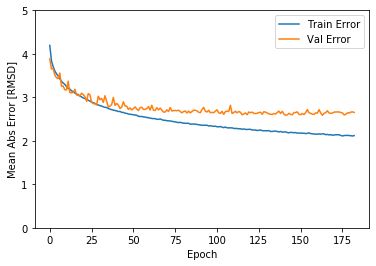

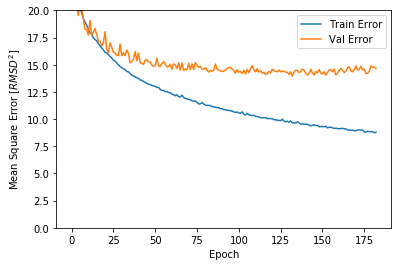

In [11]:
%matplotlib inline
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [RMSD]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label='Val Error')
    plt.ylim([0, 5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$RMSD^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label='Val Error')
    plt.ylim([0, 20])
    plt.legend()
    plt.show()


plot_history(history)

In [12]:

loss, mae, mse = model.evaluate(x_test, y_test, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} RMSD".format(mae))

Testing set Mean Abs Error:  2.68 RMSD


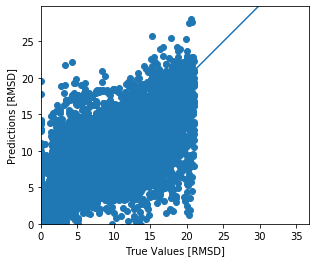

In [13]:
test_predictions = model.predict(x_test)

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [RMSD]')
plt.ylabel('Predictions [RMSD]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

plt.show()

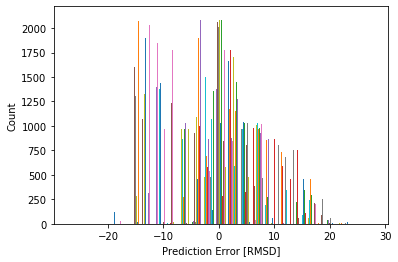

In [14]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [RMSD]")
_ = plt.ylabel("Count")
plt.show()